# Benchmark Nengo Models

This notebook runs a collection of different models using `nengo_loihi`, and compares the resultling behaviour to that of the same model running in Nengo.  These benchmarks were created before we started development of `nengo_loihi`, and are meant to exercise some of the more complex structures that we used in developing Spaun.

To run these benchmarks, you will require:

 - https://github.com/tcstewar/pytry   
 - https://github.com/nengo/nengo-benchmarks
 - https://pandas.pydata.org/
 - http://scikit-learn.org
 
To install these, do the following:
```
git clone https://github.com/tcstewar/pytry
pip install -e pytry
https://github.com/nengo/nengo-benchmarks
pip install -e nengo-benchmarks
pip install pandas
pip install scikit-learn
```

Each of the benchmarks consist of:
 - a set of parameters to adjust the benchmark
 - a Nengo model created based on those parameters
 - a plot showing the qualitative performance of the model
 - a set of quantitative measures from running the model
 
For this notebook, we adjust some of the benchmark parameters.  The main reason is to reduce some of the models to be small enough to fit on a single Loihi chip.  We also adjust dt for accuracy reasons.

It is important to note that Nengo benchmarks are not meant to produce bit-accurate identical results on different hardware platforms, so we do not expect identical performance between the different backends, as they use different neuron models and have different connectivity constraints.  Our long-term goal is to make them as similar as possible across a wide range of parameter settings.  Currently, half of the benchmarks are qualitatively similar between reference Nengo and Loihi.  For the other half of the benchmarks, much of the difference in performance seems to be due to a known issue in how `nengo-loihi` forms recurrent connections https://github.com/nengo/nengo-loihi/issues/114 which is currently being investigated and improved.  We group the benchmarks below into passing and non-passing based on this performance.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import nengo_benchmarks
import nengo_loihi
import pandas

import warnings
warnings.filterwarnings('ignore')   # hides warning messages to remove clutter

For each of these benchmarks, we will run the model in mutliple conditions.  Here is our list of conditions:

In [2]:
conditions = [
    'nengo',                                                                  # the normal nengo backend
    'nengo_loihi(precompute=False, target="sim", remove_passthrough=True)',   # using the nengo_loihi simulator
    'nengo_loihi(precompute=False, target="loihi", remove_passthrough=True)', # using Loihi itself
]

This script will run a given benchmark using the provided arguments in all the conditions requested, showing the plots and returning a pandas.DataFrame with the quantitative results.

In [3]:
import traceback
def test(name, kwargs):
    trial = getattr(nengo_benchmarks, name)()
    
    params = []
    for name, desc in trial.param_descriptions.items():
        if name in trial.system_params:
            continue
        if name in ['backend', 'neuron_type']:
            continue
        value = kwargs.get(name, trial.param_defaults[name])
        params.append((name, value, desc))
    for name, value, desc in sorted(params):
        print("  %15s = %-10r (%s)" % (name, value, desc))
     
    results = []
    for i, condition in enumerate(conditions):
        plt.figure(figsize=(12,3))
        try:
            r = trial.run(backend=condition, plt=plt, verbose=False, **kwargs)
        except Exception as e:
            traceback.print_exc()
            r = {}            
        r['condition'] = condition
        results.append(r)
        plt.suptitle(condition)
        plt.show()
    return pandas.DataFrame(results)

# Passing Benchmarks

These are benchmarks whose performance is qualitatively similar to the benchmark in normal CPU-based nengo.

## Communication Channel

We start with a very simple model: A chain of Ensembles which are just passing their input to their output.  We feed in a 2-dimensional value to the first Ensemble, and it does an identity function decode to the next, and that one to the next, and so on.  The ideal output is the same as the input, and we compute the RMS error.

                D = 2          (number of dimensions)
                L = 2          (number of layers)
                N = 100        (number of neurons per layer)
                T = 1.0        (simulation time)
               dt = 0.0001     (nengo timestep)
             pstc = 0.01       (synaptic time constant)
             seed = 1          (random number seed)


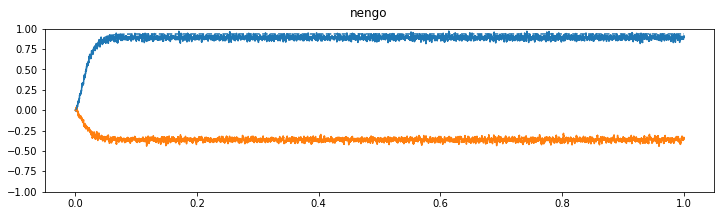

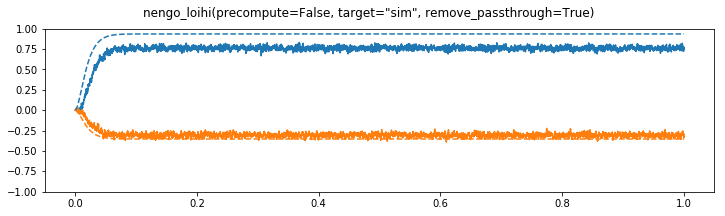

SLURM is being run in background
Connecting to 10.212.98.103:18861


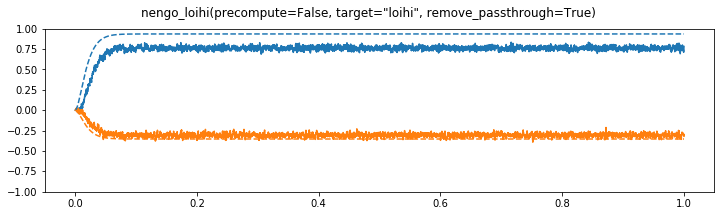

,condition,rmse,speed
0,nengo,0.038049,0.102279
1,"nengo_loihi(precompute=False, target=""sim"", re...",0.132959,0.118510
2,"nengo_loihi(precompute=False, target=""loihi"", ...",0.132773,0.013802


In [8]:
test('CommunicationChannel', dict(dt=0.0001))

## Circular Convolution

Next we have Circular Convolution.  Two randomly chosen D-dimensional vectors are the input, and the output should be the circular convolution of the two.  We use this operation extensively in our large-scale cognitive models (such as Spaun), and it requires very dense connectivity, making it well-suited for stressing the routing of information between neurons.

We restrict this to 4 dimensions to allow it to fit on one Loihi core.  In Spaun, we use 512 dimensions.  It should be noted here that we generally do not care about the magnitude of the result -- it's the direction that matters for most SPA models.

                D = 4          (dimensionality)
               SD = 8          (subdimensions)
                T = 0.5        (time to run simulation)
               dt = 0.0001     (nengo timestep)
          n_cconv = 200        (neurons per cconv)
          n_per_d = 50         (neurons per dimension I/O)
             pstc = 0.01       (post-synaptic time constant)
             seed = 1          (random number seed)


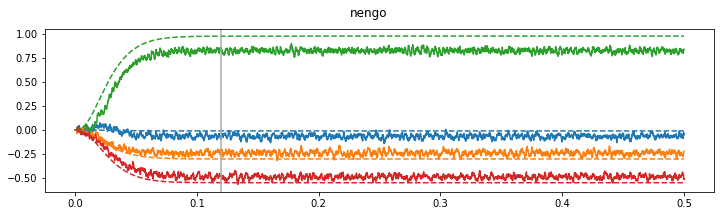

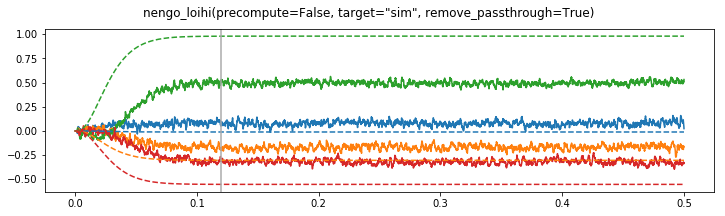

SLURM is being run in background
Connecting to 10.212.98.103:18861


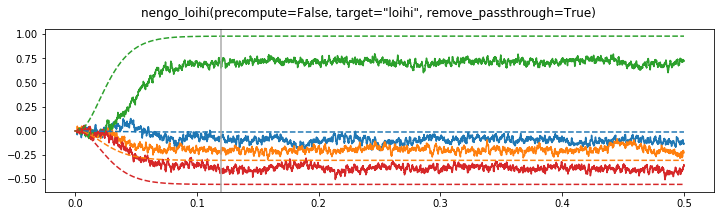

,condition,rmse,speed
0,nengo,0.094877,0.031045
1,"nengo_loihi(precompute=False, target=""sim"", re...",0.282547,0.016723
2,"nengo_loihi(precompute=False, target=""loihi"", ...",0.174720,0.012020


In [9]:
test('CircularConvolution', dict(dt=0.0001, D=4))

## Inhibition

This is a simple test that ensures that having one group of neurons inhibit another works, and is scaled correctly.  This is needed to many congnitive control tasks.  The Ensemble being inhibited as an initial value of 1, and the amount of inhibition should linearly increase until that Ensemble is completely suppressed (and thus represents 0).

                D = 1          (number of dimensions)
                T = 3.0        (time to run)
               dt = 0.001      (nengo timestep)
     inh_strength = 2.0        (inhibition strength)
        n_neurons = 100        (number of neurons)
             seed = 1          (random number seed)


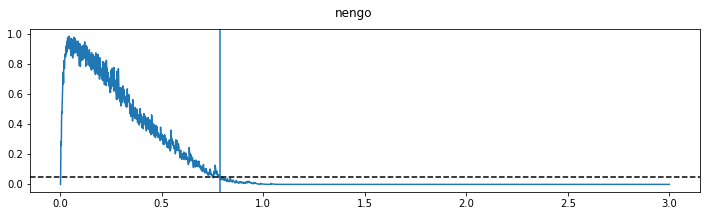

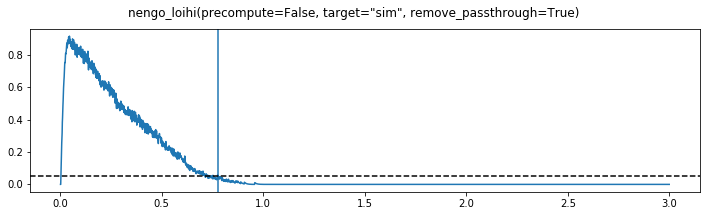

SLURM is being run in background
Connecting to 10.212.98.103:18861


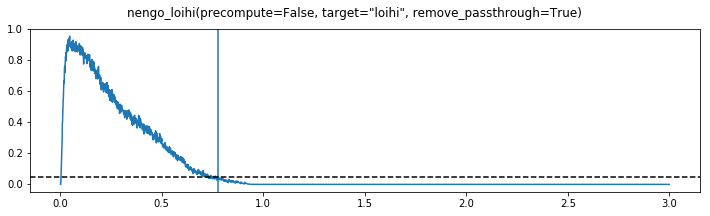

,condition,speed,time_to_inhibit
0,nengo,2.180765,0.789
1,"nengo_loihi(precompute=False, target=""sim"", re...",0.934919,0.775
2,"nengo_loihi(precompute=False, target=""loihi"", ...",0.124387,0.775


In [10]:
test('InhibitionTrial', dict(dt=0.001))

## Learning Speedup

This is a self-supervised learning benchmark where the system tries to learn to predict its own output.  However, halfway through the benchmark, the mapping from input to output is changed, and so it now needs to learn this new mapping.  This is a simplified version of the model presented in http://compneuro.uwaterloo.ca/publications/aubin2016a.html as a model of the development of learning addition facts.

One slight oddity about this benchmark is that the Loihi performance matches the normal nengo performance better with a learning rate that is 10% smaller than the nengo one.  To demonstrate this, we run the benchmark twice with different learning rates.

In [ ]:
test('LearningSpeedup', dict(dt=0.0001, learn_rate=2e-4, T=10))

In [ ]:
test('LearningSpeedup', dict(dt=0.0001, learn_rate=2e-5, T=10))

## Lorenz Attractor

As a test of implementing arbitrary dynamical systems, we implement the chaotic Lorenz attractor.  This has no input at all and should produce a chaotic pattern.

                N = 330        (number of neurons)
                T = 10.0       (time to run simulation)
             beta = 2.6666666666666665 (Lorenz variable)
               dt = 0.001      (nengo timestep)
              rho = 28.0       (Lorenz variable)
             seed = 1          (random number seed)
            sigma = 10.0       (Lorenz variable)
              tau = 0.1        (post-synaptic time constant)


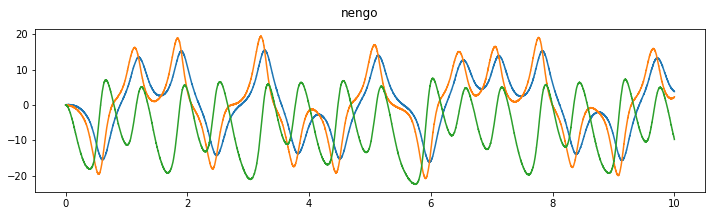

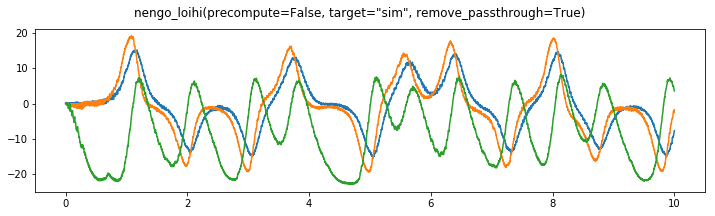

SLURM is being run in background
Connecting to 10.212.98.103:18861


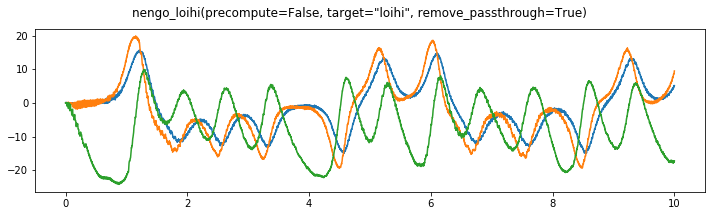

,condition,mean,speed,std
0,nengo,-1.719092,2.076270,8.779023
1,"nengo_loihi(precompute=False, target=""sim"", re...",-3.294929,0.561689,8.484621
2,"nengo_loihi(precompute=False, target=""loihi"", ...",-3.708813,0.133708,8.205334


In [13]:
test('Lorenz', dict(dt=0.001, N=330))

## Matrix Multiplication

Here we build a model that can multiply any given two matrices together (of dimensions D1xD2 and D2xD3).

               D1 = 1          (size of matrices)
               D2 = 2          (size of matrices)
               D3 = 2          (size of matrices)
                N = 50         (number of neurons for input&output)
           N_mult = 200        (number of neurons for pairwise multiply)
                T = 0.5        (time to run simulation)
               dt = 0.0001     (nengo timestep)
             pstc = 0.01       (post-synaptic time constant)
           radius = 1          (range of values)
             seed = 5          (random number seed)


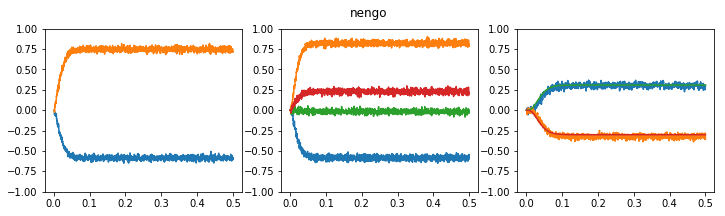

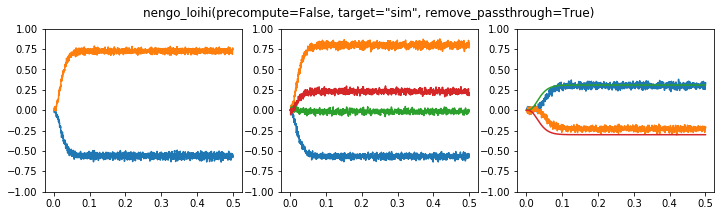

SLURM is being run in background
Connecting to 10.212.98.106:18861


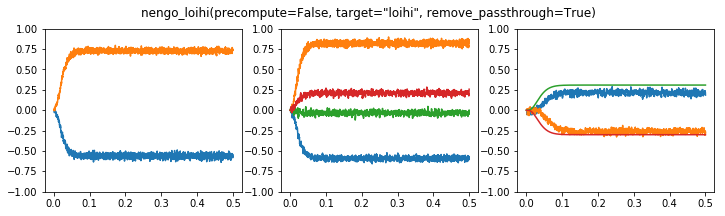

,condition,rmse,speed
0,nengo,0.027519,0.034418
1,"nengo_loihi(precompute=False, target=""sim"", re...",0.063548,0.024895
2,"nengo_loihi(precompute=False, target=""loihi"", ...",0.081534,0.007383


In [5]:
test('MatrixMultiply', dict(dt=0.0001, seed=5))

## SPA Sequence

Here we implement the model of the cortex-basal ganglia-thalamus loop described in http://compneuro.uwaterloo.ca/publications/stewart2010a.html and which we have used as the basis of cognitive control for Spaun and a variety of other models.  In this case, we configure it to go through a sequence of states.  If the cortex is in state A, then the basal ganglia and thalamus drive the cortex towards state B.  If it is in B, it will be driven towards C, and so on.

While this benchmark does perform correctly in terms of generating a sequeunce, the cycle time is slower than it should be.  This is likely due to the extra time caused by introducing interneurons between populations, and can be reduced by using `weights=True` solvers.  However, while this difference would make it difficult to perform a comparison to biological data, it is still functionally useful for the cognitive control tasks that it is generally used for, so we consider it to be a passing benchmark.


                D = 8          (dimensionality)
                T = 4          (time to simulate)
               dt = 0.0005     (nengo timestep)
        n_actions = 3          (number of actions)
             seed = 1          (random number seed)


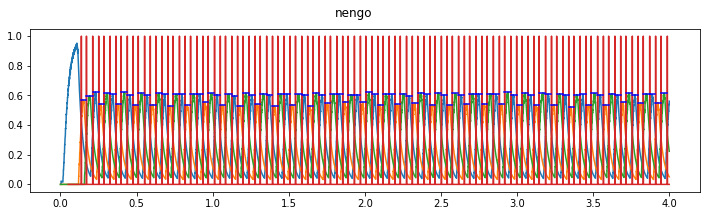

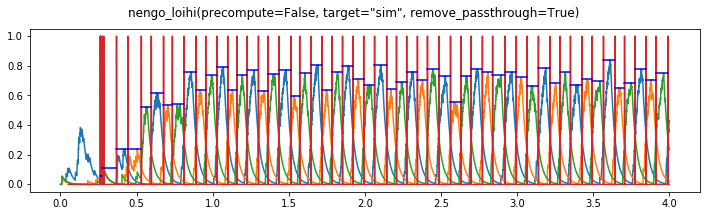

SLURM is being run in background
Connecting to 10.212.98.103:18861


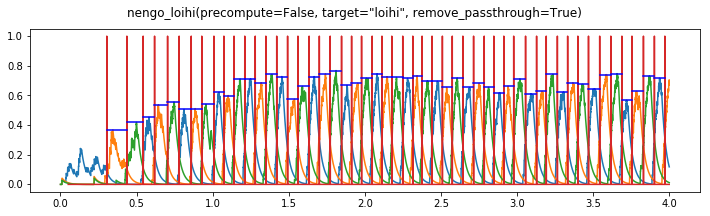

,condition,peak,peak_sd,period,period_sd,speed
0,nengo,0.586236,0.033228,0.038119,0.002968,0.081644
1,"nengo_loihi(precompute=False, target=""sim"", re...",0.634318,0.208271,0.066589,0.018097,0.051805
2,"nengo_loihi(precompute=False, target=""loihi"", ...",0.654114,0.089449,0.071892,0.011000,0.043025


In [15]:
test('SPASequence', dict(dt=0.0005, n_actions=3, D=8, T=4))

# Non-passing Benchmarks

The following benchmarks run, but do not produce results close enough to the standard nengo results for us to consider them to be passing.  For all of them, the problem seems to be due to integrator stability. As discussed in  https://github.com/nengo/nengo-loihi/issues/114 our current method of configuring recurrently connected neurons has some stability problems and we are looking into various methods for fixing this.

## Convolution with Cleanup

This benchmark stores bound information into a working memory, and then tries to extract the information from that memory via unbinding (circular correlation).  The binding and unbinding parts are identical to the Convolution benchmark above, but the information seems to decay out of the working memory much more quickly on Loihi.

                D = 2          (dimensionality)
               dt = 0.0001     (nengo timestep)
  mem_input_scale = 0.5        (input scaling on memory)
          mem_tau = 0.1        (memory time constant)
             seed = 1          (random number seed)
  test_present_time = 0.1        (amount of time per test)
        test_time = 2.0        (amount of time to test memory for)


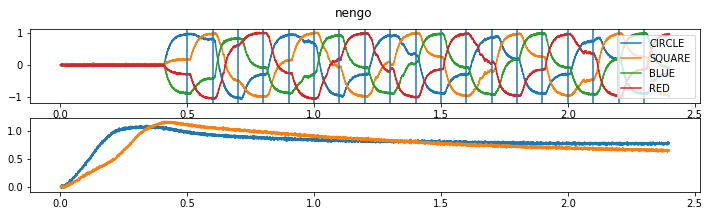

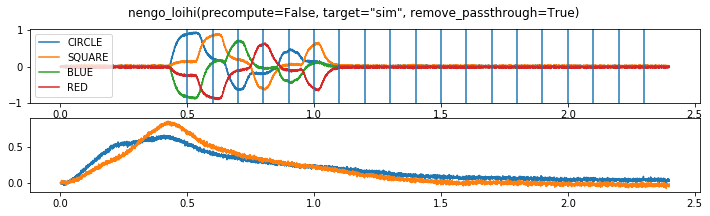

SLURM is being run in background
Connecting to 10.212.98.103:18861


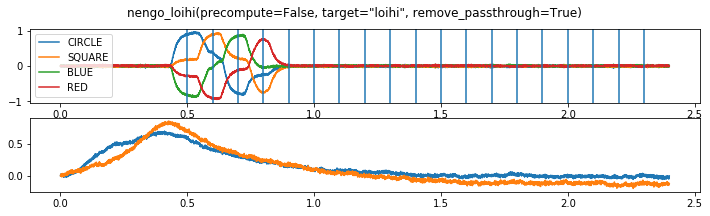

,condition,mean_recall_strength,speed
0,nengo,0.936892,0.014226
1,"nengo_loihi(precompute=False, target=""sim"", re...",0.213540,0.012937
2,"nengo_loihi(precompute=False, target=""loihi"", ...",0.180567,0.008482


In [16]:
test('ConvolutionCleanup', dict(dt=0.0001, D=2))

## Semantic memory

This benchmark tests encoding multiple pairs of bound symbols into a long-term memory, using the same structural components as are used in Spaun and other large-scale cognitive models.  Each symbol pair is presented for `time_per_symbol` seconds and the result should be stored in memory.

Since the memory here is also a recurrent neural connection, it also decays too quickly for this test to be considered passing.

                D = 4          (dimensions)
                T = 1.0        (time to recall)
               dt = 0.0001     (nengo timestep)
        n_symbols = 4          (number of symbols)
             seed = 1          (random number seed)
  time_per_symbol = 0.2        (time per symbol)


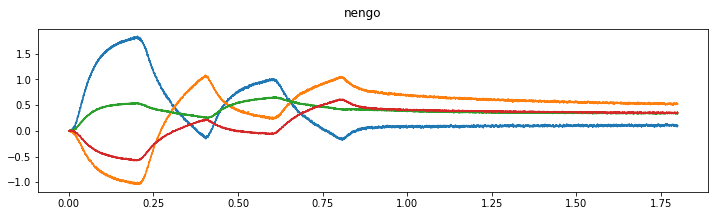

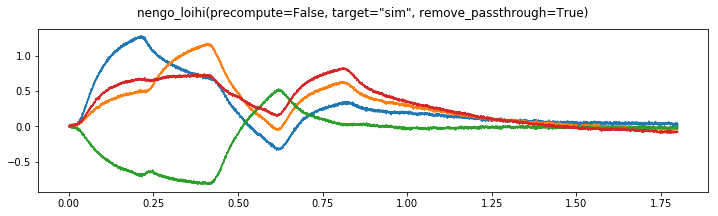

SLURM is being run in background
Connecting to 10.212.98.103:18861


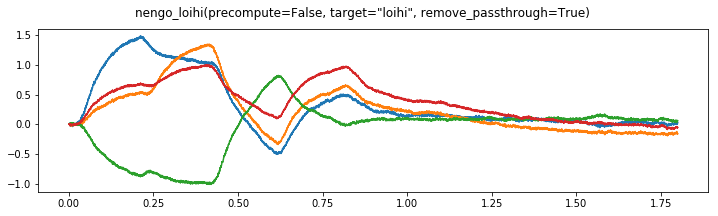

,condition,memory,speed
0,nengo,0.330181,0.027641
1,"nengo_loihi(precompute=False, target=""sim"", re...",-0.025319,0.015347
2,"nengo_loihi(precompute=False, target=""loihi"", ...",-0.031672,0.010009


In [17]:
test('SemanticMemory', dict(dt=0.0001, D=4))

## Semantic Memory with Recall

This benchmark is the same as the Semantic Memory benchmark, but adds neural systems to extract information out of the memory via unbinding (similar to the Convolution with Cleanup benchmark).  As with the Semantic Memory benchmark, the memory decays too quickly for it to be considered passing.

In [ ]:
test('SemanticMemoryWithRecall', dict(dt=0.0001, D=4))

## SPA Sequence with Routing

This expands the SPA Sequence Benchmark with routing information that is stored in one group of neurons (rather than always going back to A to restart the sequence).  This is important for large-scale cognitive models as it allows cognitive control over the flow of information between brain regions, and it produces an interesting behavioural prediction as routing information is slightly slower than directly sending a fixed pattern (as in the SPA Sequence benchmark).

As with the other non-passing benchmarks, this routed information appears to decay away too quickly to be useful.

                D = 8          (dimensionality)
                T = 4          (time to simulate)
               dt = 0.0005     (nengo timestep)
        n_actions = 3          (number of actions)
             seed = 1          (random number seed)
            start = 0          (starting action)


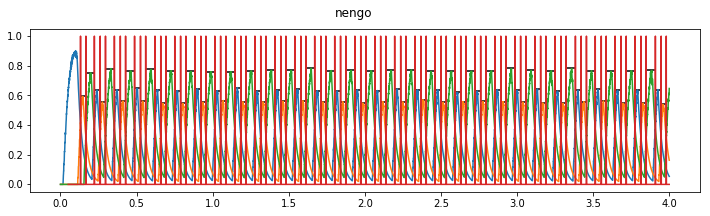

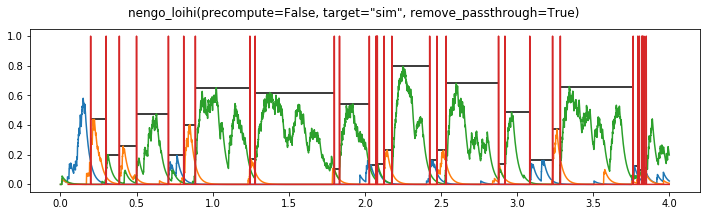

SLURM is being run in background
Connecting to 10.212.98.103:18861


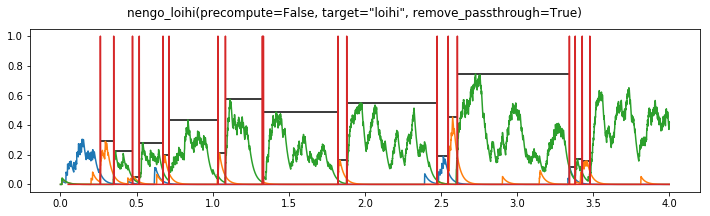

,condition,peak,peak_sd,period,period_sd,route_period,route_period_sd,speed
0,nengo,0.652783,0.087360,0.036475,0.002267,0.058500,0.001091,0.071051
1,"nengo_loihi(precompute=False, target=""sim"", re...",0.291117,0.216086,0.053694,0.039571,0.206462,0.169316,0.051798
2,"nengo_loihi(precompute=False, target=""loihi"", ...",0.295648,0.193788,0.050450,0.020557,0.338875,0.229440,0.039055


In [19]:
test('SPASequenceRouted', dict(dt=0.0005, n_actions=3, D=8, T=4))

## Parsing

This is the most complicated benchmark and implements a simple parser that can accept two-word commands and then execute them.  The words are presented sequentially and then it performs the action.  However, its internal memory decays too quickly, leading to the incorrect output.

                D = 5          (dimensions)
               dt = 0.0005     (nengo timestep)
             seed = 1          (random number seed)
    time_per_word = 0.5        (time per word)


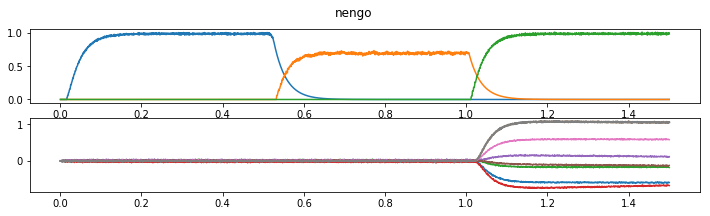

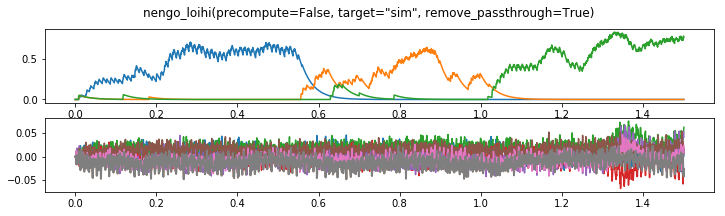

SLURM is being run in background
Connecting to 10.212.98.103:18861


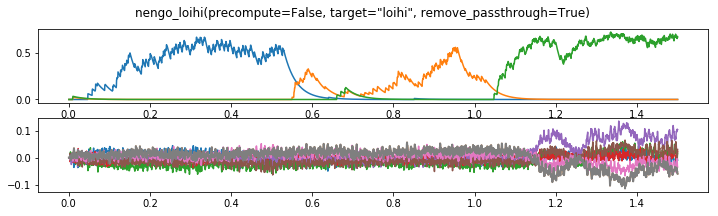

,condition,mag_correct,mag_others,mag_second,speed
0,nengo,1.065088,-0.142980,0.592504,0.049722
1,"nengo_loihi(precompute=False, target=""sim"", re...",-0.007853,0.007426,0.033109,0.045146
2,"nengo_loihi(precompute=False, target=""loihi"", ...",-0.049064,0.017354,0.075621,0.028047


In [23]:
test('Parsing', dict(dt=0.0005, D=5))

## Oscillator

The final non-passing benchmark is the Oscillator.  This is a controlled oscillator, with an input that should adjust its frequency.  We evaluate it by computing the fourier transform of its output for varying input levels.  However, due to the recurrent network decay issue, the oscillator value decays down to zero, giving a very weak signal, and the frequency of oscillation is not what is expected.

        N_control = 100        (number of control neurons)
            N_osc = 1000       (number of oscillator neurons)
                T = 10.0       (time per freq)
               dt = 0.001      (nengo timestep)
            f_max = 2.0        (maximum frequency)
           n_freq = 7          (number of freqs)
             pstc = 0.1        (post-synaptic time constant)
             seed = 1          (random number seed)


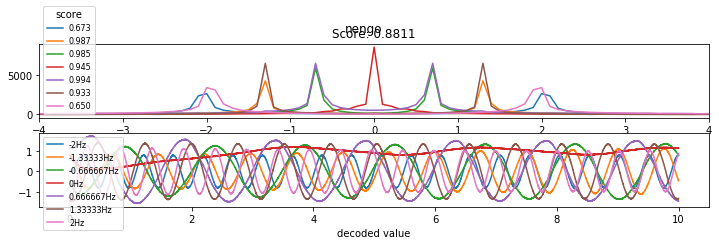

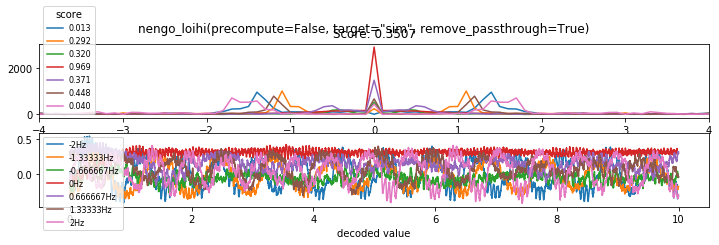

SLURM is being run in background
Connecting to 10.212.98.103:18861


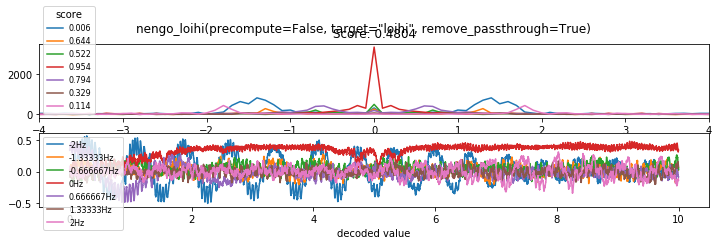

,condition,mean_score,scores,speed
0,nengo,0.881080,"[0.6726878890800575, 0.9867507488814307, 0.985...",1.652179
1,"nengo_loihi(precompute=False, target=""sim"", re...",0.350664,"[0.01349373228114239, 0.29207181737210763, 0.3...",0.268792
2,"nengo_loihi(precompute=False, target=""loihi"", ...",0.480447,"[0.006262711236837078, 0.6438834648683287, 0.5...",0.123636


In [21]:
test('Oscillator', dict(dt=0.001))

# Non-running Benchmarks

## MNIST as a Simple Function

This benchmark attempts to classify MNIST digits in the most naive way possible: simply feed the entire MNIST image into a 784-dimensional ensemble and decode out the category.  This does not use convnets or any optimization at all on the input layer (they are random weights, not anything gabor-like).  With enough neurons, this can perform perfectly well on MNIST, but the number of weights becomes very large.  `nengo-loihi` does not yet have the ability to automatically split Ensembles across cores, so this benchmark is limited to using 60 neurons so that its weight matrix can fit on a core.

While this benchmark runs reasonably on our Loihi Simulator, we currently do not support having 768 inputs to a single core (our limit is 512 on Loihi itself).

               dt = 0.001      (nengo timestep)
    learning_rate = 0.001      (learning rate)
       n_backprop = 0          (iterations of backprop to run)
       n_feedback = 0          (iterations of feedback alignment to run)
        n_neurons = 60         (number of neurons)
        n_testing = 100        (testing samples)
       n_training = 5000       (training samples)
              reg = 0.1        (regularization)
             seed = 1          (random number seed)
          synapse = 0.02       (output synapse)
          t_image = 0.1        (time per image)
        use_gabor = False      (use Gabor encoders)


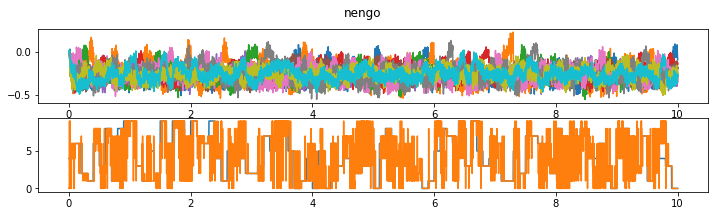

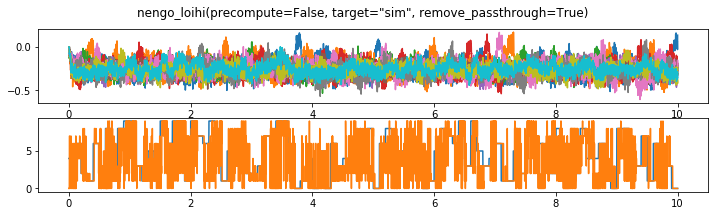

SLURM is being run in background
Connecting to 10.212.98.103:18861


Traceback (most recent call last):
  File "<ipython-input-5-7ef331346862>", line 20, in test
    r = trial.run(backend=condition, plt=plt, verbose=False, **kwargs)
  File "/homes/celiasmith/terry/pytry/pytry/trial.py", line 88, in run
    result = self.execute_trial(p)
  File "/homes/celiasmith/terry/pytry/pytry/nengo.py", line 115, in execute_trial
    return super(NengoTrial, self).execute_trial(p)
  File "/homes/celiasmith/terry/pytry/pytry/plot.py", line 24, in execute_trial
    result = super(PlotTrial, self).execute_trial(p)
  File "/homes/celiasmith/terry/pytry/pytry/trial.py", line 113, in execute_trial
    return self.do_evaluate(p)
  File "/homes/celiasmith/terry/pytry/pytry/nengo.py", line 118, in do_evaluate
    return self.evaluate(p, self.sim, self.plt)
  File "/homes/celiasmith/terry/nengo_benchmarks/nengo_benchmarks/mnist.py", line 94, in evaluate
    sim.run(T)
  File "/homes/celiasmith/terry/nengo-loihi/nengo_loihi/simulator.py", line 389, in run
    self.run_steps(st

<Figure size 864x216 with 0 Axes>

,condition,confusion,count,score,speed
0,nengo,"[[7, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 10, 0, 0,...","[7, 10, 11, 10, 10, 14, 12, 6, 9, 11]",0.64,2.450108
1,"nengo_loihi(precompute=False, target=""sim"", re...","[[7, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 9, 0, 0, ...","[7, 10, 11, 10, 10, 14, 12, 6, 9, 11]",0.54,0.079633
2,"nengo_loihi(precompute=False, target=""loihi"", ...",NaN,NaN,NaN,NaN


In [22]:
test('MNIST', dict(n_neurons=60, dt=0.001))